# Using Neural Nerwork To Solve The Newclassical Growth Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate 
from matplotlib.ticker import PercentFormatter

## Define The Neural Network: layer, width, activation function

In [2]:
class NN(nn.Module):
    def __init__(self, 
                 dim_hidden = 32,
                layers = 3,
                hidden_bias = True):
        super().__init__()
        self.dim_hidden= dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias
        
        torch.manual_seed(101)
        module = []
        module.append(nn.Linear(1,self.dim_hidden, bias = self.hidden_bias))
        module.append(nn.Softplus())
        
        for i in range(self.layers-1):
            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module.append(nn.Softplus())
                    
        module.append(nn.Linear(self.dim_hidden,1))
        module.append(nn.Sigmoid())
        
        self.u = nn.Sequential(*module)


    def forward(self, x):
        u_out = self.u(x)
        return  u_out

## Define The Parameters: discount rate, depreciation rate, risk aversion, capital range

In [3]:
class Data:
    def __init__(self,
                 beta = 0.9,
                 alpha = 0.5,
                 sigma= 1, #risk aversion
                 gamma= 0.15, #discount rate
                 kmax = 20.0, 
                 kmin =  0.1,
                 num = 500,
                 batch_size = 100
                ):
        self.beta = beta
        self.alpha = alpha
        self.sigma = sigma
        self.gamma = gamma
        self.kmax = kmax
        self.kmin = kmin
        self.num = num
        self.batch_size = batch_size                  
        self.train_data = torch.linspace(kmin,kmax,num).reshape(num,1)

In [4]:
from torch.utils.data import Dataset, DataLoader

In [5]:
class Data_loader(Dataset):
    
    def __init__(self,data):
        self.data = data
        self.K = self.data[:,[0]]
        self.n_samples = self.data.shape[0]

    def __getitem__(self,index):
            return self.K[index]
        
    def __len__(self):
        return self.n_samples

In [6]:
data_set = Data().train_data
data_label = Data_loader(data = data_set)
print(data_set.shape[0])
batch_size = Data().batch_size
train = DataLoader(dataset = data_label, batch_size = batch_size, shuffle = True)

500


In [7]:
α = Data().alpha
γ = Data().gamma
β = Data().beta
σ = Data().sigma
print(α)

0.5


In [8]:
max_epochs = 5001

In [9]:
c_hat = NN()
learning_rate = 2e-3

optimizer = torch.optim.Adam(c_hat.parameters(), lr=learning_rate, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)

## Define The Loss Function and Start Learning Process

In [10]:
for epoch in range(max_epochs):
    for index, K in enumerate(train):
        
        K_prime = (K.pow(α)+(1-γ)*K)*(1-c_hat(K))
        C_next = (K_prime.pow(α)+(1-γ)*K_prime)*c_hat(K_prime)
        C_current = (K.pow(α)+(1-γ)*K)*c_hat(K)
        euler_res = β*(C_next.pow(-σ))*(1-γ+α*K_prime.pow(α-1))-C_current.pow(-σ)
        
        loss = euler_res.pow(2).mean()
       
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
    scheduler.step()
    
    if epoch % 100 == 0:
        #print("epoch:",",",epoch,',',"{:.2e}".format(loss.item()),',',"{:.2e}".format(get_lr(optimizer))) 
        print("epoch:",epoch, ",","MSE Euler Residuals:","{:.2e}".format(loss.item()))    


epoch: 0 , MSE Euler Residuals: 1.45e-03
epoch: 100 , MSE Euler Residuals: 3.90e-05
epoch: 200 , MSE Euler Residuals: 2.06e-04
epoch: 300 , MSE Euler Residuals: 1.41e-05
epoch: 400 , MSE Euler Residuals: 1.21e-05
epoch: 500 , MSE Euler Residuals: 4.02e-06
epoch: 600 , MSE Euler Residuals: 1.38e-06
epoch: 700 , MSE Euler Residuals: 1.02e-05
epoch: 800 , MSE Euler Residuals: 2.62e-05
epoch: 900 , MSE Euler Residuals: 7.86e-06
epoch: 1000 , MSE Euler Residuals: 2.43e-06
epoch: 1100 , MSE Euler Residuals: 1.55e-06
epoch: 1200 , MSE Euler Residuals: 1.44e-06
epoch: 1300 , MSE Euler Residuals: 7.27e-07
epoch: 1400 , MSE Euler Residuals: 4.60e-06
epoch: 1500 , MSE Euler Residuals: 2.51e-06
epoch: 1600 , MSE Euler Residuals: 5.65e-06
epoch: 1700 , MSE Euler Residuals: 1.87e-05
epoch: 1800 , MSE Euler Residuals: 1.97e-06
epoch: 1900 , MSE Euler Residuals: 9.98e-07
epoch: 2000 , MSE Euler Residuals: 1.09e-06
epoch: 2100 , MSE Euler Residuals: 4.99e-06
epoch: 2200 , MSE Euler Residuals: 1.34e-05


In [11]:
c_hat.eval()
K = Data().train_data[:,[0]]
approx_sol = (K.pow(α)+(1-γ)*K)*c_hat(K).detach()
K_prime=K.pow(α)+(1-γ)*K-approx_sol

# Using Policy Function Iteration For Comparasion

In [12]:
beta = 0.9
alpha = 0.5
sigma= 1
gamma= 0.15
kmax = 20.0
kmin =  0.1
num = 500
K_n=np.linspace(kmin,kmax,num)

In [13]:
C_n=0.1*K_n  #initial value of C(K)

d=1
tol=1e-13
N=0

while  d>tol:
    Kp=K_n**alpha+(1-gamma)*K_n-C_n
    Iterp1=interpolate.interp1d(K_n,C_n)
    Cp=Iterp1(Kp)
    Cnew=Cp*(beta*(alpha*Kp**(alpha-1)+1-gamma))**(-1/sigma)
    d=max(abs(Cnew-C_n))
    C_n=Cnew
    N=N+1

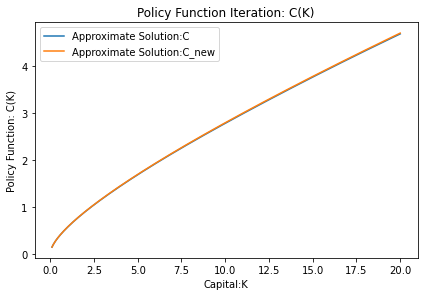

In [14]:
plt.plot(K,approx_sol,label= r"Approximate Solution:C" )
plt.plot(K_n,C_n,label= r"Approximate Solution:C_new" )
plt.ylabel(r"Policy Function: C(K)")
plt.xlabel(r"Capital:K")
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("Consumpt_0.pdf")
plt.title("Policy Function Iteration: C(K)")
plt.show()

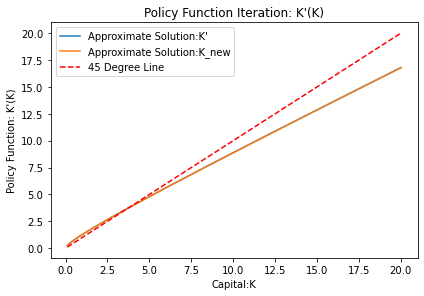

In [15]:
plt.plot(K,K_prime,label= r"Approximate Solution:K'" )
plt.plot(K_n,Kp,label= r"Approximate Solution:K_new" )
plt.plot(K,K, "--", color='r', label= r"45 Degree Line")
plt.ylabel(r"Policy Function: K'(K)")
plt.xlabel(r"Capital:K")
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("K_prime_0.pdf")
plt.title("Policy Function Iteration: K'(K)")
plt.show()

# Differences Between Two Approaches

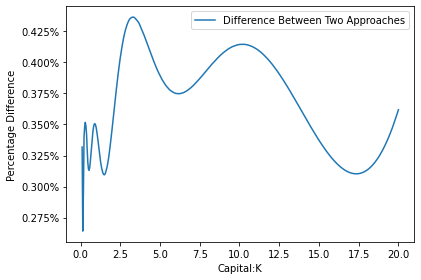

In [16]:
C_0=approx_sol.numpy()
C_1=C_n.reshape(num,1)
Distance=abs(C_1-C_0)/C_1
plt.plot(K_n,Distance,label= r"Difference Between Two Approaches" )
plt.ylabel(r"Percentage Difference")
plt.xlabel(r"Capital:K")
plt.tight_layout()
plt.legend(loc='best')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=3))
plt.show()